In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 

from scipy.io import loadmat
import numpy as np
import torch.utils.data
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from scipy import misc
import matplotlib.patches as patches
from datetime import datetime
from scipy.misc import imshow
import model_code.multi_modal_nn as mmnn
from model_code.face_landmark_dataset import FaceLandmarksDataset
import model_code.test as test
import model_code.train as train
 


In [97]:
import os
import errno

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

In [98]:
import os,random

def get_sample_folders(family_number, sample_size = 4):
    img_url = '/media/flash/DATA/processing_frames/%d/tc_faces/' % (family_number)
    
    list = os.listdir(img_url) # dir is your directory path
    number_files = len(list)
    only_files = len(next(os.walk(img_url))[2]) #dir is your directory path as string
    n = number_files - only_files


    folder_sample = random.sample(range(1,n + 1), sample_size)
    
    
    return folder_sample

In [99]:
def get_folder_image_count(family_number, folder_num):
    img_url = '/media/flash/DATA/processing_frames/%d/tc_faces/' % (family_number)
    image_list = os.listdir(img_url + str(folder_num))
    number_images = len(image_list)
    
    return number_images

In [100]:
def get_folder_file_count(url):
    image_list = os.listdir(url)
    number_images = len(image_list)
    
    return number_images

In [101]:
def get_folder_test_data_offset(family_number, folder_num):
    img_url = '/media/flash/DATA/processing_frames/%d/tc_faces/' % (family_number)
    offset = 0
    for i in range(1,folder_num):
        offset += get_folder_image_count(family_number, i)
        
    return offset


total = get_folder_test_data_offset(404, 5)
print(total)

35652


In [102]:
def extract_data(indices, suffix = '', include_pos = True, include_rand_folders = False):
  ftrs = torch.Tensor()
  ftrs = ftrs.type(torch.cuda.FloatTensor)  
  gz = torch.Tensor()
  gz = gz.type(torch.cuda.FloatTensor) 
    
  eye_reg = torch.Tensor()
  eye_reg = eye_reg.type(torch.cuda.IntTensor)
    
    
  img_loc = np.asarray([])
#   img_loc = img_loc.type(torch.cuda.FloatTensor) 
  
  for index in indices:
    data = loadmat(str(index) + '_lmarks_location_eye.mat')
    
    #Landmark features
    ftrs_single = torch.from_numpy(data['ftrs'])    
    ftrs_single = ftrs_single.type(torch.cuda.FloatTensor)  
    
    #Gaze features
    gz_single = torch.from_numpy(data['gz'])
    gz_single = gz_single.type(torch.cuda.FloatTensor)  
    gz_single = torch.t(gz_single)
    
    #Eye regions should be n X 4 size    
    eye_reg_single = torch.from_numpy(data['eye_reg'])
    eye_reg_single = eye_reg_single.type(torch.cuda.IntTensor)
    
    #Get image location    
    img_loc_single = data['location']
        
    
    if(include_rand_folders is True):
        rand_folders = get_sample_folders(index)
        
        for rand_folder in rand_folders:
            offset = get_folder_test_data_offset(index, rand_folder)
            
            begin = 0
            end = begin + 1000
            ftrs = torch.cat((ftrs, ftrs_single[offset + begin:offset + end]))
            gz = torch.cat((gz, gz_single[offset + begin:offset + end]))
            eye_reg = torch.cat((eye_reg, eye_reg_single[offset + begin:offset + end]))
            img_loc = np.concatenate((img_loc, img_loc_single[offset + begin:offset + end]))
            
        
    else:
        ftrs = torch.cat((ftrs, ftrs_single))
        gz = torch.cat((gz, gz_single))
        eye_reg = torch.cat((eye_reg, eye_reg_single))
        img_loc = np.concatenate((img_loc, img_loc_single))
    
    
    

  return(ftrs, gz, eye_reg, img_loc)


In [104]:
test_indices = [404]

test_ftrs = torch.Tensor().cuda()
test_gz = torch.Tensor().cuda()

(test_ftrs, test_gz, test_eye_reg, test_img_loc) = extract_data(test_indices, include_rand_folders=False)

print(test_gz.shape)
print(test_ftrs.shape)

torch.Size([76649, 1])
torch.Size([76649, 136])


In [105]:
test_face_landmarks_dataset = FaceLandmarksDataset(ftrs = test_ftrs, eye_regions=test_eye_reg.cuda(), locations=test_img_loc,  gz = test_gz.cuda(), train_transforms=None, test_transforms=None, load_type='test')
testloader = torch.utils.data.DataLoader(dataset=test_face_landmarks_dataset , batch_size=1, shuffle=False)


/media/flash/DATA/processing_frames/404/tc_faces/1/009157.png 


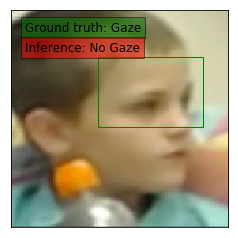

In [88]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches


chosen_sample = 1000
(rect_x, rect_y, width, height) = test_eye_reg[chosen_sample]


print(test_img_loc[chosen_sample])
im = cv2.imread(test_img_loc[chosen_sample].strip())





plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.text(10, 15, 'Ground truth: Gaze', fontsize=12, bbox=dict(facecolor='g', alpha=0.5))
plt.text(10, 30, 'Inference: No Gaze', fontsize=12, bbox=dict(facecolor='r', alpha=0.5))



rect = patches.Rectangle((rect_x, rect_y),width ,height,linewidth=1,edgecolor='g',facecolor='none')


ax = plt.gca()

ax.add_patch(rect)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('results_picture/404/000031.png',bbox_inches='tight', pad_inches=0)

plt.show()

In [106]:
(net,optimizer) = mmnn.get_net_instance()
net.load_state_dict(torch.load('model_code/log_results/18/models/multimodal_model_18_128_epoch_6.py'))


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [107]:
print(test_face_landmarks_dataset[0])

(tensor([2.6000e+01, 7.7000e+01, 2.8000e+01,  ..., 2.5990e-03, 2.5990e-03,
        2.5990e-03], device='cuda:0'), tensor([0.], device='cuda:0'))


In [108]:
family_samples = {'407': [3, 13, 12, 10], '404': [1, 13, 7, 8], '410': [13, 5, 9, 11]}#{'404' : get_sample_folders(404), '407' : get_sample_folders(407), '410' : get_sample_folders(410)}

In [109]:
print(family_samples)

{'407': [3, 13, 12, 10], '404': [1, 13, 7, 8], '410': [13, 5, 9, 11]}


In [110]:
13 not in family_samples['404']

False

('PROSO', 1)
('PROSO', 2)
('PROSO', 3)
('PROSO', 4)
('PROSO', 5)
('PROSO', 6)
('PROSO', 7)
('PROSO', 8)
('PROSO', 9)
('PROSO', 10)
('PROSO', 11)
('PROSO', 12)
('PROSO', 13)
('PROSO', 14)
('PROSO', 15)
('PROSO', 16)
('PROSO', 17)
('PROSO', 18)
('PROSO', 19)
('PROSO', 20)
('PROSO', 21)
('PROSO', 22)
('PROSO', 23)
('PROSO', 24)
('PROSO', 25)
('PROSO', 26)
('PROSO', 27)
('PROSO', 28)
('PROSO', 29)
('PROSO', 30)
('PROSO', 31)
('PROSO', 32)
('PROSO', 33)
('PROSO', 34)
('PROSO', 35)
('PROSO', 36)
('PROSO', 37)
('PROSO', 38)
('PROSO', 39)
('PROSO', 40)
('PROSO', 41)
('PROSO', 42)
('PROSO', 43)
('PROSO', 44)
('PROSO', 45)
('PROSO', 46)
('PROSO', 47)
('PROSO', 48)
('PROSO', 49)
('PROSO', 50)
('PROSO', 51)
('PROSO', 52)
('PROSO', 53)
('PROSO', 54)
('PROSO', 55)
('PROSO', 56)
('PROSO', 57)
('PROSO', 58)
('PROSO', 59)
('PROSO', 60)
('PROSO', 61)
('PROSO', 62)
('PROSO', 63)
('PROSO', 64)
('PROSO', 65)
('PROSO', 66)
('PROSO', 67)
('PROSO', 68)
('PROSO', 69)
('PROSO', 70)
('PROSO', 71)
('PROSO', 72)
(

('PROSO', 554)
('PROSO', 555)
('PROSO', 556)
('PROSO', 557)
('PROSO', 558)
('PROSO', 559)
('PROSO', 560)
('PROSO', 561)
('PROSO', 562)
('PROSO', 563)
('PROSO', 564)
('PROSO', 565)
('PROSO', 566)
('PROSO', 567)
('PROSO', 568)
('PROSO', 569)
('PROSO', 570)
('PROSO', 571)
('PROSO', 572)
('PROSO', 573)
('PROSO', 574)
('PROSO', 575)
('PROSO', 576)
('PROSO', 577)
('PROSO', 578)
('PROSO', 579)
('PROSO', 580)
('PROSO', 581)
('PROSO', 582)
('PROSO', 583)
('PROSO', 584)
('PROSO', 585)
('PROSO', 586)
('PROSO', 587)
('PROSO', 588)
('PROSO', 589)
('PROSO', 590)
('PROSO', 591)
('PROSO', 592)
('PROSO', 593)
('PROSO', 594)
('PROSO', 595)
('PROSO', 596)
('PROSO', 597)
('PROSO', 598)
('PROSO', 599)
('PROSO', 600)
('PROSO', 601)
('PROSO', 602)
('PROSO', 603)
('PROSO', 604)
('PROSO', 605)
('PROSO', 606)
('PROSO', 607)
('PROSO', 608)
('PROSO', 609)
('PROSO', 610)
('PROSO', 611)
('PROSO', 612)
('PROSO', 613)
('PROSO', 614)
('PROSO', 615)
('PROSO', 616)
('PROSO', 617)
('PROSO', 618)
('PROSO', 619)
('PROSO', 

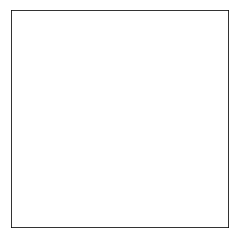

In [111]:
import re

pattern = re.compile(r'\d+')


testloader_iterator = iter(testloader)

for chosen_sample in range(0, len(test_face_landmarks_dataset)):
    try:
        location = test_img_loc[chosen_sample].strip()
        folder = int(pattern.findall(location)[1])
        family = int(pattern.findall(location)[0])

        folder_loc = 'results_picture/%d/%d/' % (family, folder)

        make_sure_path_exists('results_picture/%d/%d/' % (family, folder))


        if(get_folder_file_count(folder_loc) > 1000 or 
             folder not in family_samples[str(family)]):
    #         print(get_folder_file_count(folder_loc), str(folder) ,family_samples[str(family)])
            continue
    #         (x_batch, y_batch) = train_batch



        (x_batch, y_batch) = next(testloader_iterator)


        optimizer.zero_grad()
        yhat = torch.Tensor()
        yhat = yhat.type(torch.cuda.FloatTensor)  


        yhat = net(x_batch) 


        yhat = yhat > 0.5

        inference_label = bool(yhat[0][0])
        ground_truth_label = bool(y_batch)






        (rect_x, rect_y, width, height) = test_eye_reg[chosen_sample]


        im = cv2.imread(test_img_loc[chosen_sample].strip())
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))


        facecolor_gt = 'g' if ground_truth_label is True else 'r'
        facecolor_inf = 'g' if inference_label is True else 'r'
        text_gt = 'Ground truth: Gaze' if ground_truth_label is True else 'Ground truth: No Gaze'
        text_inf = 'Inference: Gaze' if inference_label is True else 'Inference: No Gaze'


        plt.text(10, 15, text_gt, fontsize=8, bbox=dict(facecolor=facecolor_gt, alpha=0.5))
        plt.text(10, 30, text_inf, fontsize=8, bbox=dict(facecolor=facecolor_inf, alpha=0.5))
        rect = patches.Rectangle((rect_x, rect_y),width ,height,linewidth=1,edgecolor='b',facecolor='none')



        ax = plt.gca()

    #     ax.add_patch(rect)

        #########################################################################################
        preds = test_ftrs[chosen_sample]

        preds = preds.cpu().numpy()
        x = preds[0:135:2]
        y = preds[1:136:2]

        left_eye = (42,48)
        right_eye = (36,42)

        brows = (17,27)

        plt.plot(x[left_eye[0]:left_eye[1]], y[left_eye[0]:left_eye[1]], 'x', color='c')
        plt.plot(x[right_eye[0]:right_eye[1]], y[right_eye[0]:right_eye[1]], 'x', color='b')


        plt.plot(x[brows[0]:brows[1]], y[brows[0]:brows[1]], 'x', color='g')


        #########################################################################################
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        image_padded = str(chosen_sample).rjust(8, '0')


        fig_loc = 'results_picture/%d/%d/%s' % (family, folder, image_padded)
        fig_loc += '.png'

        plt.savefig(fig_loc,bbox_inches='tight', pad_inches=0)

        if chosen_sample % 100 == 0:
            print(chosen_sample)

                
        print('PROSO', get_folder_file_count(folder_loc))


        plt.cla()
    except Exception:
        continue
        

In [ ]:
import re

pattern = re.compile(r'\d+')
family = int(pattern.findall('/media/flash/DATA/processing_frames/404/tc_faces/12')[0])

folder = int(pattern.findall('/media/flash/DATA/processing_frames/404/tc_faces/12')[1])
print(family,folder)

In [ ]:
t = '112'
pad = t.rjust(8, '0')

print(pad)